# Chapter 5: Extra code, drafts, and cut material

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Beta-binomial demos

In [2]:
from scipy.special import binom, betaln

def beta_binom(prior, y):
    """
    Compute the marginal-log-likelihood for a beta-binomial model,
    analytically.

    prior : tuple
        tuple of alpha and beta parameter for the prior (beta distribution)
    y : array
        array with "1" and "0" corresponding to the success and fails respectively
    """
    α, β = prior
    success = np.sum(y)
    trials = len(y)
    return np.log(binom(trials, success)) + betaln(α + success, β+trials-success) - betaln(α, β)

In [3]:
def posterior_grid(ngrid=10, α=1, β=1, heads=6, trials=9):
    grid = np.linspace(0, 1, ngrid)
    prior = stats.beta(α, β).pdf(grid)
    likelihood = stats.binom.pmf(heads, trials, grid)
    posterior = likelihood * prior
    posterior /= posterior.sum()
    return posterior

In [4]:
def normal_harmonic(sd_0, sd_1, y, s=10000):
    post_tau = 1/sd_0**2 + 1/sd_1**2
    posterior_samples = stats.norm(loc=(y/sd_1**2)/post_tau, scale=(1/post_tau)**0.5).rvs((s, len(x)))
    log_likelihood = stats.norm.logpdf(loc=x, scale=sd_1, x=posterior_samples).sum(1)
    return 1/np.mean(1/log_likelihood)

In [5]:
from scipy import stats
σ_0 = 1
σ_1 = 1
y = np.array([0])
stats.norm.logpdf(loc=0, scale=(σ_0**2+σ_1**2)**0.5, x=y).sum()

-1.2655121234846454

In [6]:
def posterior_ml_ic_normal(σ_0=1, σ_1=1, y=[1]):
    n = len(y)
    var_μ = 1/((1/σ_0**2) + (n/σ_1**2))
    μ = var_μ * np.sum(y)/σ_1**2
    σ_μ = var_μ**0.5

    posterior = stats.norm(loc=μ, scale=σ_μ)
    samples = posterior.rvs(size=(2, 1000))
    log_likelihood = stats.norm(loc=samples[:, :, None], scale=σ_1).logpdf(y)
    idata = az.from_dict(log_likelihood={'o': log_likelihood})

    log_ml = stats.norm.logpdf(loc=0, scale=(σ_0**2+σ_1**2)**0.5, x=y).sum()
    
    x = np.linspace(-5, 6, 300)
    density = posterior.pdf(x)
    
    return μ, σ_μ, x, density, log_ml, az.waic(idata).elpd_waic, az.loo(idata, reff=1).elpd_loo

Text(0.5, 0, 'μ')

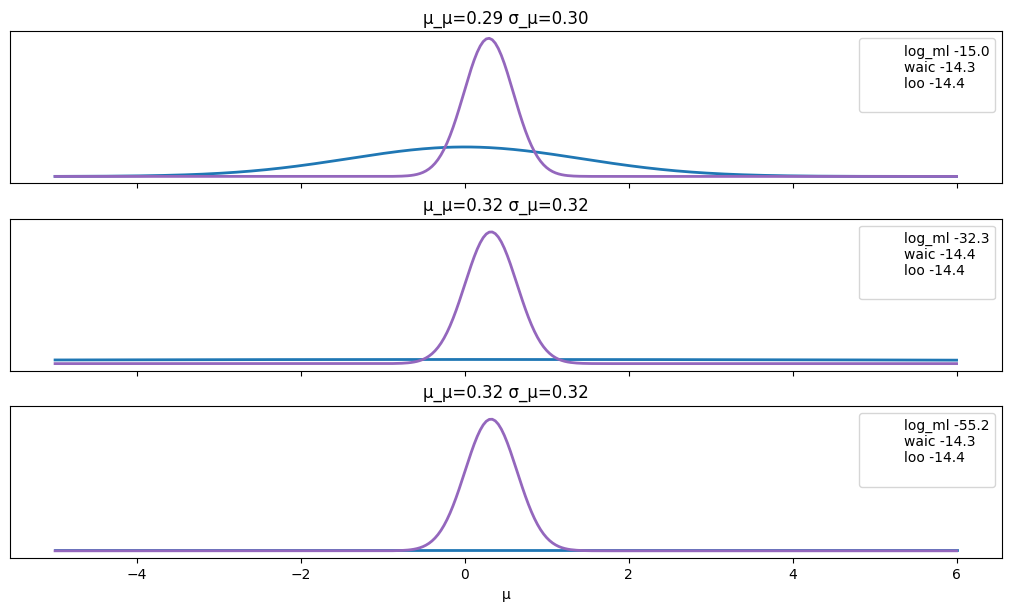

In [7]:
import arviz as az

y = np.array([ 0.65225338, -0.06122589,  0.27745188,  1.38026371, -0.72751008,
              -1.10323829,  2.07122286, -0.52652711,  0.51528113,  0.71297661])

_, ax = plt.subplots(3, figsize=(10, 6), sharex=True, sharey=True,
                     constrained_layout=True)

for i, σ_0 in enumerate((1, 10, 100)):
    μ_μ, σ_μ, x, density, log_ml, waic, loo = posterior_ml_ic_normal(σ_0, σ_1, y)
    ax[i].plot(x, stats.norm(loc=0, scale=(σ_0**2+σ_1**2)**0.5).pdf(x), lw=2)
    ax[i].plot(x, density, lw=2, color='C4')
    ax[i].plot(0, label=f'log_ml {log_ml:.1f}\nwaic {waic:.1f}\nloo {loo:.1f}\n', alpha=0)
    ax[i].set_title(f'μ_μ={μ_μ:.2f} σ_μ={σ_μ:.2f}')
    ax[i].legend()
ax[2].set_yticks([])

ax[2].set_xlabel("μ")

#plt.savefig("img/chp11/ml_waic_loo.png")

In [8]:
σ_0 = 1
σ_1 = 1
y = np.array([0])
stats.norm.logpdf(loc=0, scale=(σ_0**2 + σ_1**2)**0.5, x=y).sum()

-1.2655121234846454

In [9]:
def posterior_grid(ngrid=10, α=1, β=1, heads=6, trials=9):
    grid = np.linspace(0, 1, ngrid)
    prior = stats.beta(α, β).pdf(grid)
    likelihood = stats.binom.pmf(heads, trials, grid)
    posterior = likelihood * prior
    posterior /= posterior.sum()
    return posterior

## Bayesian p-value

In [10]:
import pymc as pm
import numpy as np
import arviz as az

# Simulated data
np.random.seed(42)
x = np.random.normal(0, 1, 100)
y = 3 + 2 * x + np.random.normal(0, 1, 100)

# Bayesian Linear Regression Model
with pm.Model() as model:
    # Priors
    beta0 = pm.Normal("beta0", mu=0, sigma=10)
    beta1 = pm.Normal("beta1", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    # Likelihood
    mu = beta0 + beta1 * x
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
    
    # Sampling
    trace = pm.sample(2000, return_inferencedata=True)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


In [11]:
# Posterior Predictive Check
# with model:
#     ppc = pm.sample_posterior_predictive(trace)    
# Posterior Predictive Check
ppc = pm.sample_posterior_predictive(trace, model=model)
    


Sampling: [y_obs]


Output()

In [12]:
# Extract the posterior predictive samples for 'y_obs'
y_rep = ppc.posterior_predictive["y_obs"].values

# Calculate Bayesian p-value for the slope
test_stat_observed = np.mean(y)  # Example test statistic
test_stat_rep = np.mean(y_rep, axis=1)
bayesian_p_value = np.mean(test_stat_rep >= test_stat_observed)
print("Bayesian p-value:", bayesian_p_value)

Bayesian p-value: 0.49


In [13]:
# manual numerical integral function to check posterior is well normalized
def myint(xs, ys):
    delta = xs[1] - xs[0]
    return np.sum(ys) * delta

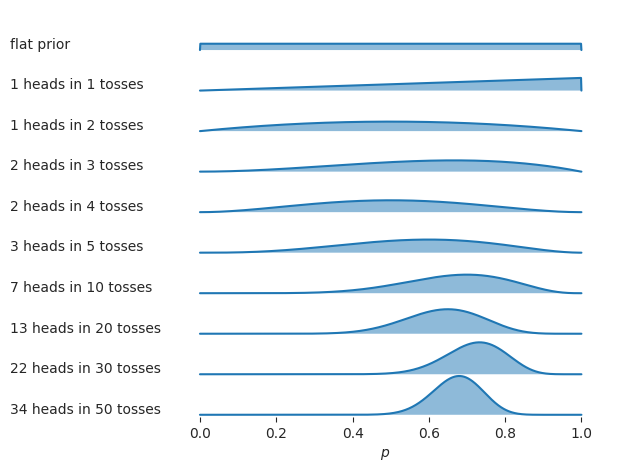

In [14]:
# FIGURES ONLY
# Inspired by  https://python-graph-gallery.com/ridgeline-graph-seaborn/
from scipy.stats import beta



n_rows = 10
ns =       [0, 1, 2, 3, 4, 5, 10, 20, 30,  50]
outcomes = [0, 1, 1, 2, 2, 3,  7, 13, 22,  34]
# outcomes were generated from coin with true p = 0.7
assert len(outcomes) == n_rows
assert len(ns) == n_rows
n_rows = int(len(outcomes))

dists = pd.DataFrame({
    "case": range(n_rows),
    "n": ns,
    "outcome": outcomes,
})

labels = []
for i in range(n_rows):
    heads, n = outcomes[i], ns[i]
    if i==0:
        label = "flat prior"
    else:
        label = f"{heads} heads in {n} tosses"
    labels.append(label)


def plot_case(heads, n, *args, **kwargs):
    rvPpost = beta(a=1+heads, b=1+n-heads)
    eps = 0.001
    ps = np.linspace(0-eps, 1.0+eps, 1000)
    rvPpdf = rvPpost.pdf(ps)
    ax = sns.lineplot(x=ps, y=rvPpdf, alpha=1)
    ax.fill_between(ps, 0, rvPpdf, alpha=0.5)

with sns.axes_style("white"), plt.rc_context({"axes.facecolor": (0, 0, 0, 0), "xtick.bottom":True}):
    g = sns.FacetGrid(dists, row='case', aspect=12, height=0.5)
    g.map(plot_case, "outcome", "n")
    
    # add labels on the left
    for i, ax in enumerate(g.axes.flat):
        ax.text(-0.5, 0.3, labels[i], fontsize=10, ha="left", multialignment="right")

    # adjust spacing to get the axes to overlap
    g.fig.subplots_adjust(hspace=-0.05)

    # other figure cleanup
    g.set(xlim=[-0.3,1.1])
    g.set(xticks=np.linspace(0,1,6))
    for i, ax in enumerate(g.axes.flat):
        if i != n_rows-1:
            # remove x-ticks (except for last)
            ax.tick_params(bottom=False)
    g.set(xlabel="               $p$")
    g.set_titles(template="")
    g.set(yticks=[])
    g.set(ylabel=None)
    g.despine(bottom=True, left=True)

    # save as PDF and PNG
    # filename = os.path.join(DESTDIR, "ridgeplot_coin_posteriors.pdf")
    # fig = plt.gcf()
    # fig.savefig(filename, dpi=300, bbox_inches="tight", pad_inches=0)
    # filename2 = filename.replace(".pdf", ".png")
    # fig.savefig(filename2, dpi=300, bbox_inches="tight", pad_inches=0)
    # print("Saved figure to", filename)    
    # print("Saved figure to", filename2)

### Maximum a posteriori estimates

In [82]:
iqs = [ 82.6, 105.5,  96.7,  84.0, 127.2,  98.8,  94.3,
       122.1,  86.8,  86.1, 107.9, 118.9, 116.5, 101.0,
        91.0, 130.0, 155.7, 120.8, 107.9, 117.1, 100.1,
       108.2,  99.8, 103.6, 108.1, 110.3, 101.8, 131.7,
       103.8, 116.4]

iqs_out = iqs.copy()
iqs_out[0] = 300
iqs_out[1] = 300
np.mean(iqs_out)

121.55333333333334

In [86]:
# ML
muso = np.linspace(-100, 300, 100001)
sigma = 15
likelihood2o = np.ones(100001)
for iq_out in iqs_out:
    likelihood_iq_out = norm(loc=muso, scale=sigma).pdf(iq_out)
    likelihood2o = likelihood2o * likelihood_iq_out

mu_ML = muso[np.argmax(likelihood2o)]
print(mu_ML)

121.55199999999999


In [88]:
# MAP
prior2o = norm(loc=100, scale=10).pdf(muso)
numerator2o = likelihood2o * prior2o
posterior2o = numerator2o / np.sum(numerator2o)

# posterior mode 
muso[np.argmax(posterior2o)]

120.048

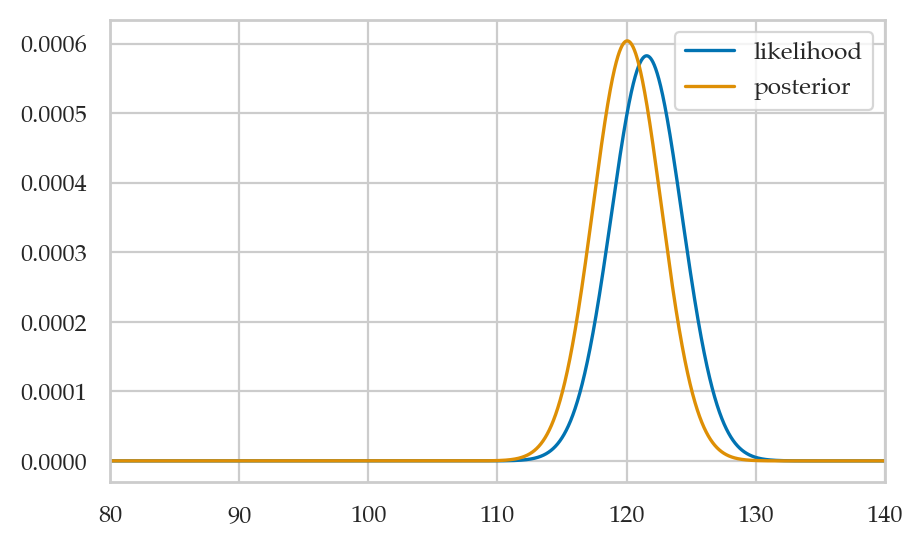

In [89]:
ax = sns.lineplot(x=muso, y=likelihood2o/np.sum(likelihood2o), label="likelihood")
sns.lineplot(x=muso, y=posterior2o/np.sum(posterior2o), ax=ax, label="posterior")
ax.set_xlim([80,140]);